In [266]:
from IPython.display import Image

In [267]:
# Figure 1
Image(url="http://www.cntk.ai/jup/sinewave.jpg")


In [268]:
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import cntk as C

%matplotlib inline
print("cntk version ",C.__version__)
print("cntk sees device(s): ",C.all_devices())

cntk version  2.1
cntk sees device(s):  (GPU[0] Tesla K80, CPU)


In [269]:
isFast = False #fewer epochs for True


def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits np.array into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]
    #print("training set repr is: ",repr(train))
    return {"train": train, "val": val, "test": test}


In [270]:
def generate_data(fct, x, time_steps, time_shift):
    """
    generate sequences to feed to rnn for fct(x)
    """
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(dict(a = data[0:len(data) - time_shift],
                                 b = data[time_shift:]))
    rnn_x = []
    for i in range(len(data) - time_steps):
        rnn_x.append(data['a'].iloc[i: i + time_steps].as_matrix())
    rnn_x = np.array(rnn_x)

    # Reshape or rearrange the data from row to columns
    # to be compatible with the input needed by the LSTM model
    # which expects 1 float per time point in a given batch
    rnn_x = rnn_x.reshape(rnn_x.shape + (1,))
    
    rnn_y = data['b'].values
    
    # Reshape or rearrange the data from row to columns
    # to match the input shape
    rnn_y = rnn_y.reshape(rnn_y.shape + (1,))

    return split_data(rnn_x), split_data(rnn_y)


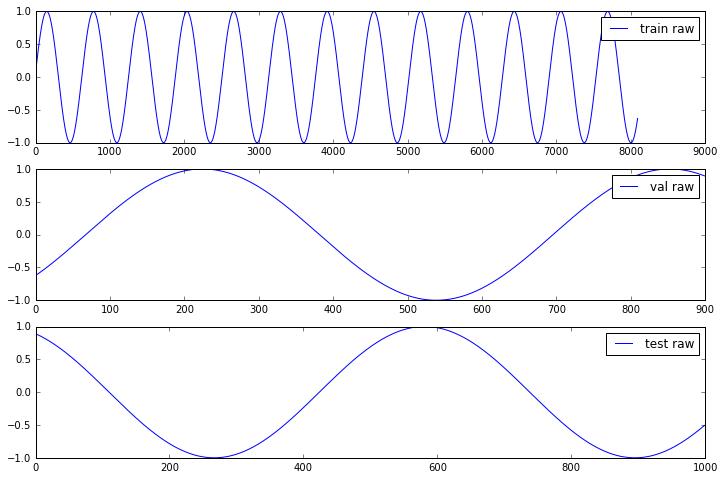

In [271]:
N = 5 # input: N subsequent values 
M = 7 # output: predict 1 value M steps ahead -orig 5
X, Y = generate_data(np.sin, np.linspace(0, 100, 10000, dtype=np.float32), N, M)

f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    a[j].plot(Y[ds], label=ds + ' raw');
[i.legend() for i in a];


In [272]:
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(N,name='LSTM'))(x)
        m = C.sequence.last(m,name='EndRNN')
        m = C.layers.Dropout(0.2, seed=1,name='Dropout')(m)
        m = C.layers.Dense(1,name='yourdensity')(m) #was 1 try 2
        return m


In [273]:
def next_batch(x, y, ds):
    """get the next batch to process"""

    def as_batch(data, start, count):
        part = []
        for i in range(start, start + count):
            part.append(data[i])
            if (i == 1):
                print(part)
        return np.array(part)

    for i in range(0, len(x[ds])-BATCH_SIZE, BATCH_SIZE):
        yield as_batch(x[ds], i, BATCH_SIZE), as_batch(y[ds], i, BATCH_SIZE)


In [274]:
# Training parameters

TRAINING_STEPS = 10000
BATCH_SIZE     = 50                    #orig = 100
EPOCHS         = 20 if isFast else 100 #orig was 20


In [275]:
# input sequences
x = C.sequence.input_variable(1)
print("x input var shape is: ", repr(x))
# create the model
z = create_model(x)
tensprint = C.logging.TensorBoardProgressWriter(freq=10, log_dir='/home/jw/notebooks/CNTK/temp/', model=z)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input

l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")
print("l input var is: ", repr(l))

# the learning rate
learning_rate = 0.001
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.squared_error(z, l)

# use squared error to determine error for now
error = C.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant, 
                      unit_gain = True)

trainer = C.Trainer(z, (loss, error), [learner],tensprint) #add for tensorboard tensprint


x input var shape is:  Input('Input15395', [#, *], [1])
l input var is:  Input('y', [#], [1])


In [276]:
 #train
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for x1, y1 in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x1, l: y1})
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.5f}".format(epoch, training_loss))

print("training took {0:.1f} sec".format(time.time() - start))


[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
epoch: 0, loss: 0.63494
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dt

[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 

[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
epoch: 50, loss: 0.07147
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], d

[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[ 

training took 41.2 sec


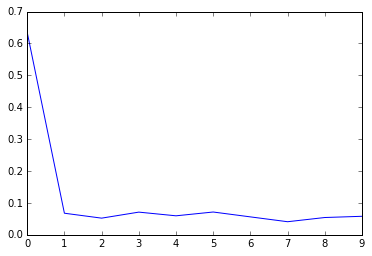

In [277]:
# A look how the loss function shows how well the model is converging
plt.plot(loss_summary, label='training loss');


In [278]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
    return result/len(X[labeltxt])


In [279]:
# Print the train and validation errors
for labeltxt in ["train", "val"]:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))


[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
mse for train: 0.000066
[array([[-0.69851506],
       [-0.6913228 ],
       [-0.68406129],
       [-0.67673141],
       [-0.66933382]], dtype=float32), array([[-0.6913228 ],
       [-0.68406129],
       [-0.67673141],
       [-0.66933382],
       [-0.66186923]], dtype=float32)]
[array([-0.62357438], dtype=float32), array([-0.61572397], dtype=float32)]
mse for val: 0.000096


In [280]:
# Print validate and test error
labeltxt = "test"
print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))


[array([[ 0.93462396],
       [ 0.93102008],
       [ 0.92732316],
       [ 0.92353338],
       [ 0.91965127]], dtype=float32), array([[ 0.93102008],
       [ 0.92732316],
       [ 0.92353338],
       [ 0.91965127],
       [ 0.91567713]], dtype=float32)]
[array([ 0.88992661], dtype=float32), array([ 0.88532019], dtype=float32)]
mse for test: 0.000109


[array([[ 0.        ],
       [ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333]], dtype=float32), array([[ 0.01000083],
       [ 0.02000067],
       [ 0.0299985 ],
       [ 0.03999333],
       [ 0.04998416]], dtype=float32)]
[array([ 0.06994984], dtype=float32), array([ 0.07992267], dtype=float32)]
[array([[-0.69851506],
       [-0.6913228 ],
       [-0.68406129],
       [-0.67673141],
       [-0.66933382]], dtype=float32), array([[-0.6913228 ],
       [-0.68406129],
       [-0.67673141],
       [-0.66933382],
       [-0.66186923]], dtype=float32)]
[array([-0.62357438], dtype=float32), array([-0.61572397], dtype=float32)]
[array([[ 0.93462396],
       [ 0.93102008],
       [ 0.92732316],
       [ 0.92353338],
       [ 0.91965127]], dtype=float32), array([[ 0.93102008],
       [ 0.92732316],
       [ 0.92353338],
       [ 0.91965127],
       [ 0.91567713]], dtype=float32)]
[array([ 0.88992661], dtype=float32), array([ 0.88532019], dtype=float32)]


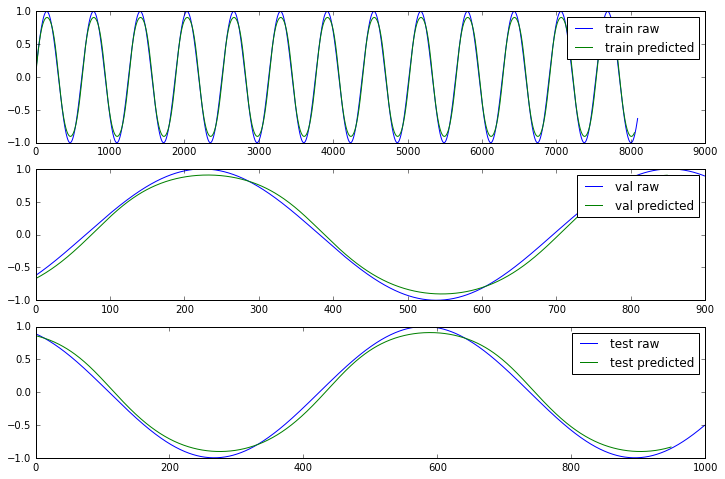

In [281]:
# predict
f, a = plt.subplots(3, 1, figsize = (12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x1, y1 in next_batch(X, Y, ds):
        pred = z.eval({x: x1})
        results.extend(pred[:, 0])
    a[j].plot(Y[ds], label = ds + ' raw');
    a[j].plot(results, label = ds + ' predicted');
[i.legend() for i in a];


In [282]:
tensprint.close()